In [4]:
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random

np.random.seed(256)
tf.random.set_seed(256)
random.seed(256)

import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [6]:
# Load the dataset
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [7]:
# Define the rating function
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'
data['Rating'] = data['Rating'].apply(rating)

data['Rating'].value_counts()

,count
Rating,
Good,15093
Bad,3214
Neutral,2184


In [8]:
# Ensure proper column names
data.columns = ['Review', 'Rating']

In [9]:
# Check for any null values
print(data.isnull().sum())


Review    0
Rating    0
dtype: int64


In [10]:
# Drop null values if any
data.dropna(inplace=True)

In [11]:
# Hyperparameters
max_length = 100
epochs = 5  # Increase the number of epochs
batch_size = 16
learning_rate = 1e-5
num_classes = 3  # Number of classes (0 to 5)

In [12]:

# Load the pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False  # Freeze BERT layers

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

In [13]:
# Define the input layers
input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
token_type_ids = Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')

# Define a custom layer to wrap the BERT model
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state

bert_layer = BertLayer(bert_model)

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Convert numerical categories to strings
data['Rating'] = data['Rating'].astype(str)



Unique labels: ['Bad', 'Good', 'Neutral']
Number of classes: 3


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
# Verify the unique labels and their counts
unique_labels = sorted(data['Rating'].unique())
num_classes = len(unique_labels)
print(f"Unique labels after conversion: {unique_labels}")
print(f"Number of classes: {num_classes}")

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 100

# Tokenize the data with padding and truncation
inputs = tokenizer(list(data['Review']), padding='max_length', truncation=True, max_length=max_length, return_tensors='np')
input_ids_np = inputs['input_ids']
attention_mask_np = inputs['attention_mask']
token_type_ids_np = inputs['token_type_ids']

# Convert labels to one-hot encoded format
encoder = OneHotEncoder(sparse=False, categories=[unique_labels])
target_label_one_hot = encoder.fit_transform(data['Rating'].values.reshape(-1, 1))

# Split the dataset into training and validation sets
input_ids_train, input_ids_val, attention_mask_train, attention_mask_val, token_type_ids_train, token_type_ids_val, y_train, y_val = train_test_split(
    input_ids_np, attention_mask_np, token_type_ids_np, target_label_one_hot, test_size=0.2, random_state=42, shuffle=True)

Unique labels after conversion: ['Bad', 'Good', 'Neutral']
Number of classes: 3


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
# Create a BERT model
def create_model():
    bert_outputs = bert_layer([input_ids, attention_mask, token_type_ids])
    pooled_output = GlobalAveragePooling1D()(bert_outputs)
    dropout = Dropout(0.1)(pooled_output)
    output = Dense(num_classes, activation='softmax')(dropout)  
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)
    return model

# Define the model
model_BERT = create_model()

# Compile the model
model_BERT.compile(optimizer=Adam(learning_rate=learning_rate), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model_BERT.summary()


# Define callbacks
model_es = EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, mode='min')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_type_ids            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 100, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0],  │
│                           │                        │                │ token_type_ids[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ bert_layer[0][0]       │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │          2,307 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model with detailed logging
history = model_BERT.fit(
    {'input_ids': input_ids_train, 'attention_mask': attention_mask_train, 'token_type_ids': token_type_ids_train},
    y_train,
    validation_data=({'input_ids': input_ids_val, 'attention_mask': attention_mask_val, 'token_type_ids': token_type_ids_val}, y_val),
    epochs=epochs, batch_size=batch_size,
    callbacks=[model_es, model_rlr]
)


Epoch 1/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 142s 121ms/step - accuracy: 0.6023 - loss: 0.9212 - val_accuracy: 0.7421 - val_loss: 0.7549 - learning_rate: 1.0000e-05
Epoch 2/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 127s 124ms/step - accuracy: 0.7329 - loss: 0.7941 - val_accuracy: 0.7421 - val_loss: 0.7528 - learning_rate: 1.0000e-05
Epoch 3/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.7330 - loss: 0.7878 - val_accuracy: 0.7421 - val_loss: 0.7511 - learning_rate: 1.0000e-05
Epoch 4/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.7333 - loss: 0.7863 - val_accuracy: 0.7421 - val_loss: 0.7500 - learning_rate: 1.0000e-05
Epoch 5/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 122s 104ms/step - accuracy: 0.7338 - loss: 0.7861 - val_accuracy: 0.7421 - val_loss: 0.7492 - learning_rate: 1.0000e-05


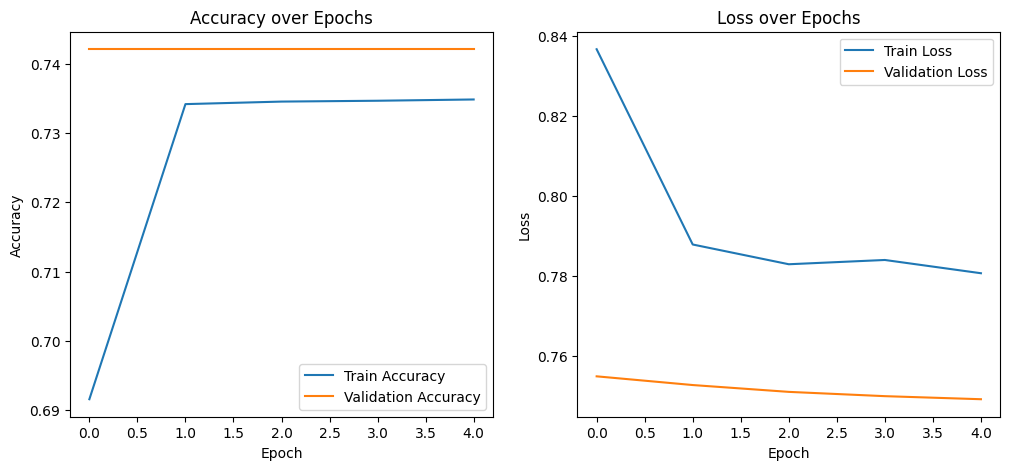

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Plot training metrics
metrics = pd.DataFrame(history.history)
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

In [21]:
# Load and preprocess test data (ensure you have a sufficient number of test samples)
test_texts = data['Review'].sample(500)  # Sample 500 reviews for testing
test_labels = data['Rating'].sample(500)  # Corresponding labels

# Tokenize the test data with padding and truncation
test_inputs = tokenizer(list(test_texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='np')
test_input_ids = test_inputs['input_ids']
test_attention_mask = test_inputs['attention_mask']
test_token_type_ids = test_inputs['token_type_ids']

# Convert test labels to one-hot encoded format
test_labels_one_hot = encoder.transform(test_labels.values.reshape(-1, 1))


In [22]:
# Evaluate the model
loss, accuracy = model_BERT.evaluate(
    {'input_ids': test_input_ids, 'attention_mask': test_attention_mask, 'token_type_ids': test_token_type_ids},
    test_labels_one_hot
)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 489ms/step - accuracy: 0.7548 - loss: 0.7351
Test Loss: 0.7288
Test Accuracy: 0.7560


In [23]:
# Generate predictions
predictions = model_BERT.predict(
    {'input_ids': test_input_ids, 'attention_mask': test_attention_mask, 'token_type_ids': test_token_type_ids}
)

# Convert one-hot encoded labels to class indices
true_labels = np.argmax(test_labels_one_hot, axis=-1)
pred_labels = np.argmax(predictions, axis=-1)

print(classification_report(true_labels, pred_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 691ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.76      1.00      0.86       378
           2       0.00      0.00      0.00        58

    accuracy                           0.76       500
   macro avg       0.25      0.33      0.29       500
weighted avg       0.57      0.76      0.65       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Print confusion matrix and classification report
print(confusion_matrix(true_labels, pred_labels))

[[  0  64   0]
 [  0 378   0]
 [  0  58   0]]


In [25]:
# Get unique class labels
unique_labels = sorted(data['Rating'].unique())

# Ensure the correct number of classes in the model
num_classes = len(unique_labels)

# Print classification report and confusion matrix
print(classification_report(true_labels, pred_labels, target_names=unique_labels))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))


              precision    recall  f1-score   support

         Bad       0.00      0.00      0.00        64
        Good       0.76      1.00      0.86       378
     Neutral       0.00      0.00      0.00        58

    accuracy                           0.76       500
   macro avg       0.25      0.33      0.29       500
weighted avg       0.57      0.76      0.65       500

Confusion Matrix:
[[  0  64   0]
 [  0 378   0]
 [  0  58   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.76      1.00      0.86       378
           2       0.00      0.00      0.00        58

    accuracy                           0.76       500
   macro avg       0.25      0.33      0.29       500
weighted avg       0.57      0.76      0.65       500



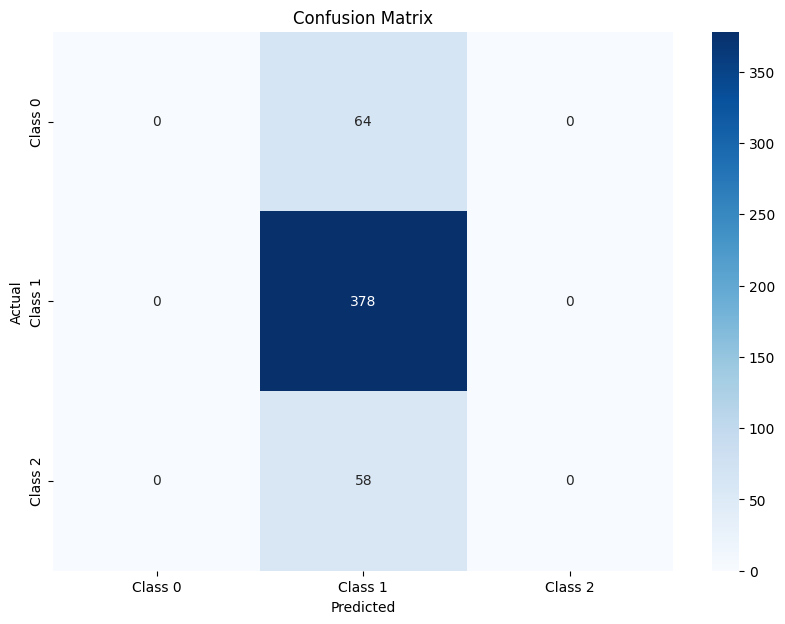

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Print classification report
print(classification_report(true_labels, pred_labels))

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],  
            yticklabels=['Class 0', 'Class 1', 'Class 2']) 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()